*Do not delete this style setting*

In [1]:
%%html
<style>
table {float:left}
</style>

# Session 2:<br>A Simple Quantum Estimator

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To explore the creation and use of a simple quantum estimator in <strong>PennyLane</strong><br>
            Note that "simplicity" is only in data and the model structure - not in the approach!</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the following two data set generators from sklearn (code below):<br>
            <ol><li>from sklearn.datasets import <strong><em>make_regression</em></strong> (Workshop)</li>
                <li>from sklearn.datasets import <strong><em>make_swiss_roll</em></strong> (Challenge)</li>
            </ol></td></tr>
    <tr><td><strong>Tasks:</strong></td>
        <td>40 minutes (unfinished tasks go to self-directed "challenges")</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at end of this notebook):<br><ol>
            <li>Initially use the <strong><em>Regression</em></strong> dataset 1 (as provided).<br>
                Follow the instructor demonstration to step through the code.</li>
            <li>Can you improve the selected model by:<br>
                - changing entangling methods (basic_ent = False/True) ?<br>
                - changing the number of qubits/wires ?<br>
                - changing the number of training epochs ?<br>
                - changing the optimiser ?<br>
                Which of these changes had the greatest impact on performance?</li>
            <li>Change data encoding by increasing the encoding margin.<br>
                What was the impact of your change? Why do you think it happened ?</li>
            <li>Calculate testing MSE and R2 scores.<br>
                Follow the example of calculating training R2.</li>
            <li>Create a plot of residuals for training and test predictions.<br>
                Note that residuals are (expected-predicted) values.</li>
            <li>Reflect on this session.</li>
        </ol></td>
    </tr>
    <tr>
        <td><strong>Challenge<br>Tasks:</strong></td>
        <td>Perform the following tasks in your own time:<br/><ol>
            <li>Complete the unfinished tasks.</li>
            <li>Change the model by incorporating the reuploading ansatz (see Session 1).</li>
            <li>Create a more insightful visualisation of residuals (research).</li>
            <li>Apply your completed model to the <strong><em>Swiss Roll</em></strong> data set 2<br>
                - see example at the end of the notebook</li>
        </ol>
        </td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><a href="https://www.youtube.com/watch?v=42aa-Ve5WmI" target="_blank">
            Catalina Albornoz, "Optimizing a quantum circuit with PennyLane",<br>PennyLane Tutorial, YouTube Video, Sept 12, 2023.</a></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
    <tr><td><strong>Changes:</strong></td>
        <td>All significant changes to this code must be listed at the bottom of this notebook</td></tr>
</table>

## Libraries

In [2]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.']

In [3]:
### General libraries

import os
import math
import time
import copy
import numpy as nnp # if wanted to use standard numpy
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
### Import utilities
from utilities import *

In [5]:
### Import PennyLane
import pennylane as qml
from pennylane import numpy as np # redefined numpy

import plotly.express as px
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error

## Load the data set

<font color="red">Task 1: Follow the instructor demonstration to step through the code.</font>

### Data set in its original form

In [6]:
# The following may preserve the chart on saving
# import plotly.io as pio
# pio.renderers.default = 'notebook' # or "jupyterlab"

np.random.seed(42)  # For reproducibility
data_seed = 42
n_samples = 100
n_features = 2

# Generate synthetic regression data
X_raw, y_raw = make_regression(
    n_samples=n_samples,
    n_features=n_features, 
    noise=5.0,
    random_state=data_seed
)
y_raw = y_raw.reshape((y_raw.shape[0], 1))

# Create an interactive 3D scatter plot, of the first two columns
fig = px.scatter_3d(x=X_raw[:, 0], y=X_raw[:, 1], z=y_raw[:, 0], 
                    title='Interactive 3D Scatter Plot',
                    labels={'x': 'Feature x', 
                            'y': 'Feature y', 
                            'z': 'Target'})
mrg = dict(l = 50, r = 50, b = 50, t = 50, pad = 10)
fig.update_traces(marker=dict(size=3, color='blue', symbol='circle'))
fig.update_layout(width=600, height=600, margin = mrg, paper_bgcolor = 'whitesmoke')
fig.show()

## Create a simple quantum model

### Model and training configuration
<font color="red">Task 2: Experiment with the model hyper-parameters.</font>

- Change entangling methods (basic_ent = False/True)
- Change the number of qubits/wires _**n_wires**_ (what happens)
- Change the number of layers _**n_layers**_
- Change the number of training epochs _**epochs**_

<font color="red">Task 3: Increase the encoding margin.</font>

- Change the value of _**x_angle_margin**_ to 0.5.
- What is the impact of this change? Why?

In [7]:
### Data params used in scaling
#   Encoded values to be scaled to range (0..pi)
#   Optionally, margins can be left out on the value boundaries
x_angle_margin = 0.1 
x_angle_min = 0+x_angle_margin
x_angle_max = np.pi-x_angle_margin

### Architectural parameters
n_wires = 2 # n_features
n_layers = 5
basic_ent = True
wires = list(range(n_wires))

### Training hyper-parameters
epochs = 50 # 20 # 50 (preferred) # 100 # 300 (long wait)
prompt_fract = 0.05 # Fraction of results shown in training
shots = None # Theoretical results will be computed
seed = 2025

### Prepare data for the quantum classifier

In [8]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
X_scaled = X_scaler.fit_transform(X_raw)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y_raw)

In [9]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                    test_size=0.33, random_state=seed, shuffle=False)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(67, 2), X_test=(33, 2), y_train=(67, 1), y_test=(33, 1)


In [10]:
### Change the data format to tensors
X_train_tens = qml.numpy.tensor(np.array(X_train), requires_grad=False)
y_train_tens = qml.numpy.tensor(np.array(y_train), requires_grad=False)
X_test_tens  = qml.numpy.tensor(np.array(X_test), requires_grad=False)
y_test_tens  = qml.numpy.tensor(np.array(y_test), requires_grad=False)

## Loss and cost function
*Note that "mse_loss" cannot be replaced by sklearn "mean_squared_error", which does not understand gradients.*<br>
*When we switch to PyTorch, we will use its range of loss functions.*

In [11]:
### Our own gradient-friendly loss function
def mse_loss(targets, predictions):
    loss = 0
    for l, p in zip(targets, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(targets)
    return loss

### The cost function generator
def cost_fun_gen(model, loss_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, loss_fun
        preds = [model(params, x) for x in inputs]
        return loss_fun(targets, preds)
    return _cost_fun

## PennyLane quantum linear model

In [12]:
### Define default device
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu
dev = qml.device(sim, wires=n_wires, shots=shots)

print(f'Device to be used:  {sim}\n')

Device to be used:  default.qubit



In [13]:
### Define a quantum linear model functionally
### This is the PennyLane style of doing things
def qlinear(n_wires, scaler=1.0, basic=False):
    def _qlinear(weights, inputs):
        nonlocal n_wires, scaler, basic
        data_wires = list(range(n_wires))
        scaled_inputs = inputs * scaler
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)  
        if basic:
            qml.BasicEntanglerLayers(weights, wires=data_wires, rotation=qml.RY)
        else:
            qml.StronglyEntanglingLayers(weights, wires=data_wires)
        return qml.expval(qml.PauliZ(0))
    return _qlinear

### Check the model shape
### This is defined so that we could select and check the shape in one place
def qlinear_shape(n_wires, n_layers=1, basic=False):
    if basic:
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

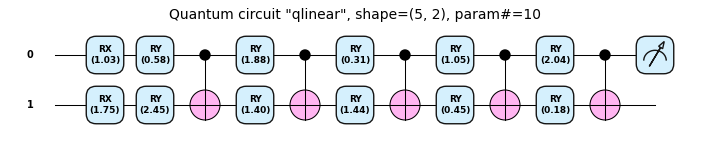

In [14]:
### Create a quantum linear model

# Prepare the quantum linear model
qmodel = qlinear(n_wires, basic=basic_ent)
qlinear_model = qml.QNode(qmodel, dev)
shape = qlinear_shape(n_wires, n_layers=n_layers, basic=basic_ent)

# Plot the model circuit (needs weights and some input)
test_params = np.random.uniform(high=np.pi, size=shape, requires_grad=True)
draw_circuit(qlinear_model, scale=0.5, 
             title=f'Quantum circuit "qlinear", shape={shape}, param#={np.prod(shape)}', level='device') \
    (test_params, X_train_tens[0]) # level='device'/'gradient'

In [15]:
### Test the model
qlinear_model(test_params, X_train_tens[0])

tensor(-0.17848355, requires_grad=True)

## Creation and training of the linear model

In [16]:
### Set the random seed
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.5)

### Define the cost function
cost_fun = cost_fun_gen(qlinear_model, mse_loss)

### Initialise the model weights / parameters
params = np.random.uniform(high=np.pi, size=shape, requires_grad=True)

### Training loop
hist_cost = []
hist_params = []
prompt_fract = 0.1
start_time = time.time() 
for iter in range(epochs):
    params, cost = opt.step_and_cost(lambda p: cost_fun(p, X_train_tens, y_train_tens), params)
    hist_cost.append(float(cost))
    hist_params.append(params)
    elapsed_time = time.time()-start_time
    if (prompt_fract == 0) or (iter % int(prompt_fract*epochs) == 0):
        print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')

### Print the training summary
train_mse_hist = hist_cost
train_min_mse = np.min(train_mse_hist)
train_min_mse_iter = np.argmin(train_mse_hist)
print(f'\nTraining completed: epochs={epochs}, '+\
      f'min cost={np.round(train_min_mse, 6)} @ {train_min_mse_iter}, '+\
      f'time={int(elapsed_time):03d} secs\n')

Iter: 000 (000 sec) cost=[0.528581]
Iter: 005 (002 sec) cost=[0.123771]
Iter: 010 (004 sec) cost=[0.061866]
Iter: 015 (005 sec) cost=[0.036531]
Iter: 020 (007 sec) cost=[0.02387]
Iter: 025 (009 sec) cost=[0.033227]
Iter: 030 (011 sec) cost=[0.025554]
Iter: 035 (013 sec) cost=[0.025297]
Iter: 040 (015 sec) cost=[0.023013]
Iter: 045 (017 sec) cost=[0.023492]

Training completed: epochs=50, min cost=0.022197 @ 49, time=018 secs



## Calculate optimum scores

**Calculate training R2 scores.**

- Note that training MSE has already been generated as part of the cost calculations.
- We need to calculate MSE score for every model generated in training.
- All scores will have to be saved in their own history list.
- Afterwards the maximum R2 (best) and its iteration will be saved as well.
- Also note that in score calculation we no longer rely on the gradient system,
  hence, we can utilise the *__sklearn__* scoring functions.

In [17]:
### Calculate training R2
train_r2_hist = []
train_max_r2 = -1000.0
train_max_r2_iter = -1

# Accumulate R2 scores
for iter in range(len(hist_params)):
    iter_params = hist_params[iter]
    train_pred = qlinear_model(iter_params, X_train_tens)
    curr_r2 = r2_score(y_train_tens, train_pred)
    train_r2_hist.append(float(curr_r2))
    if curr_r2 > train_max_r2:
        test_max_r2 = curr_r2
        test_max_r2_iter = iter

# Find the optimum training loss and R2
train_max_r2 = np.max(train_r2_hist)
train_max_r2_iter = np.argmax(train_r2_hist)

# Show training results
print(f'\nTraining results: MSE = {nnp.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'R2 = {nnp.round(train_max_r2, 5):05.4f} @ {train_max_r2_iter:04d}\n')


Training results: MSE = 0.0222 @ 0049, R2 = 0.6798 @ 0049



<font color="red">Task 4: Calculate testing MSE and R2 scores.</font>

- We need to calculate MSE and R2 scores for every model generated in training.
- All test scores will have to be saved in their own history list.
- Afterwards the maximum R2 (best) and minimum MSE (best) test scores, together with their respective location, will need to be saved as well.
- Note that moedl scoring no longer relies on the gradient system (as was the case in model training), hence, we can utilise the sklearn scoring functions (which do not support gradient calculations).

In [18]:
### Calculate testing MSE and R2

# Prepare test scores
test_mse_hist = []
test_r2_hist = []

# Initialise testing loss and R2
test_min_mse = 1000.0
test_min_mse_iter = -1
test_max_r2 = -1000.0
test_max_r2_iter = -1

# Calculate testing loss and R2
for iter in range(len(hist_params)):
    iter_params = hist_params[iter]
    test_pred = qlinear_model(iter_params, X_test_tens)
    curr_r2 = r2_score(y_test_tens, test_pred)
    curr_mse = mean_squared_error(y_test_tens, test_pred)
    test_r2_hist.append(curr_r2)
    test_mse_hist.append(curr_mse)
    if curr_r2 > test_max_r2:
        test_max_r2 = curr_r2
        test_max_r2_iter = iter
    if curr_mse < test_min_mse:
        test_min_mse = curr_mse
        test_min_mse_iter = iter

# Show test results
print(f'\nTesting results:  MSE = {nnp.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'R2 = {nnp.round(test_max_r2, 5):05.4f} @ {test_max_r2_iter:04d}\n')


Testing results:  MSE = 0.0241 @ 0034, R2 = 0.5650 @ 0034



## Plot costs and scores

### Plot MSE performance

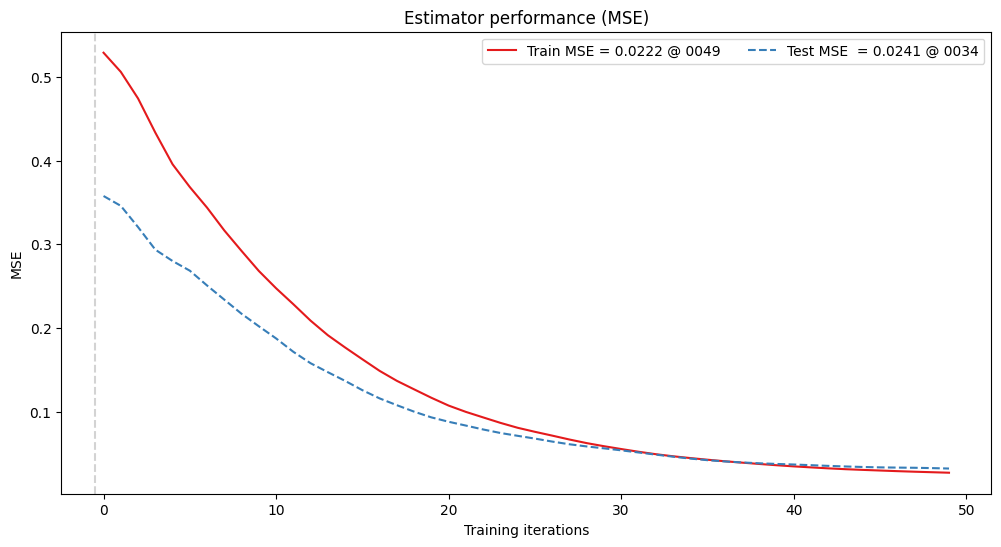

In [19]:
train_label = f'Train MSE = {nnp.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}'
test_label  = f'Test MSE  = {nnp.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}'
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='MSE',
    legend_cols=2, smooth_weight=0.9, title='Estimator performance (MSE)'
)

### Plot R2 performance

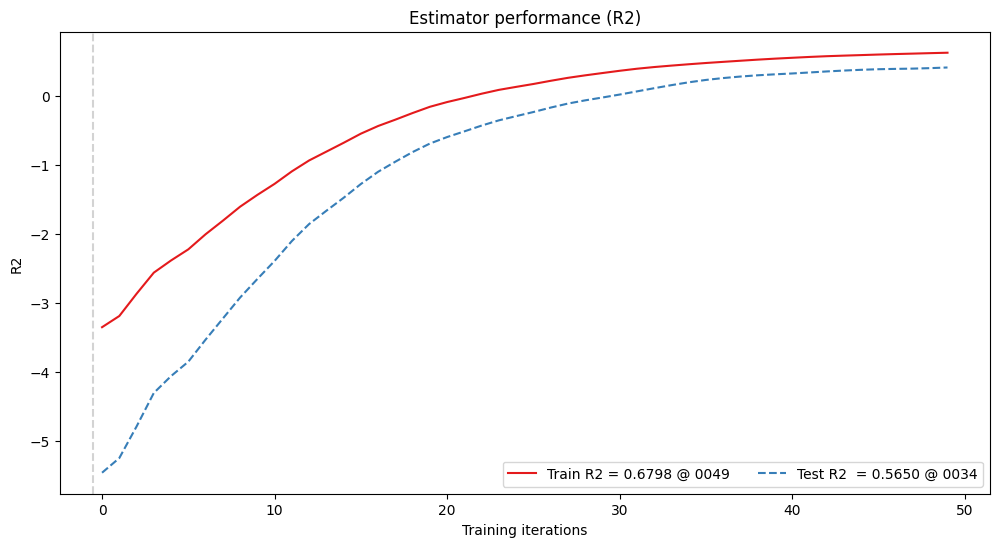

In [20]:
### Plot R2 trainnig and testing scores
train_label = f'Train R2 = {nnp.round(train_max_r2, 5):05.4f} @ {train_max_r2_iter:04d}'
test_label  = f'Test R2  = {nnp.round(test_max_r2, 5):05.4f} @ {test_max_r2_iter:04d}'

multi_plot_series(
    [train_r2_hist, test_r2_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='R2',
    legend_cols=2, smooth_weight=0.9, title='Estimator performance (R2)'
)

### Plot residuals of the expected vs predicted data
<font color="red">Task 5. Create a plot of residuals for training and test predictions.</font>

- Use the best model's parameters to derive predictions for all data.
- Note that the "best" is based on the minimum MSE test score.
- Show all results in the original data units.
- Calculate residuals as a percentage of maximum expected values.

In [21]:
### Calculate residuals (dz=expected-predicted)

# Find the predictions for training and test data
opt_test_params = hist_params[test_min_mse_iter]
y_pred_ts = qlinear_model(opt_test_params, X_test)
y_pred_tr = qlinear_model(opt_test_params, X_train)

# Rescale all data to the original units
y_pred_org_ts = y_scaler.inverse_transform(y_pred_ts.reshape((y_pred_ts.shape[0], 1)))
y_true_org_ts = y_scaler.inverse_transform(y_test.reshape((y_test.shape[0], 1)))
z_ts, zt_ts = y_pred_org_ts.reshape((y_pred_org_ts.shape[0])), y_true_org_ts.reshape((y_true_org_ts.shape[0]))
y_pred_org_tr = y_scaler.inverse_transform(y_pred_tr.reshape((y_pred_tr.shape[0], 1)))
y_true_org_tr = y_scaler.inverse_transform(y_train.reshape((y_train.shape[0], 1)))
z_tr, zt_tr = y_pred_org_tr.reshape((y_pred_org_tr.shape[0])), y_true_org_tr.reshape((y_true_org_tr.shape[0]))

# Calculate residuals (true-predicted) normalised to the 
z_range = np.max([np.abs(np.min(zt_ts)), np.abs(np.max(zt_ts)), np.abs(np.min(zt_tr)), np.abs(np.max(zt_tr))])
dz_ts = (zt_ts-z_ts) / z_range
dz_tr = (zt_tr-z_tr) / z_range

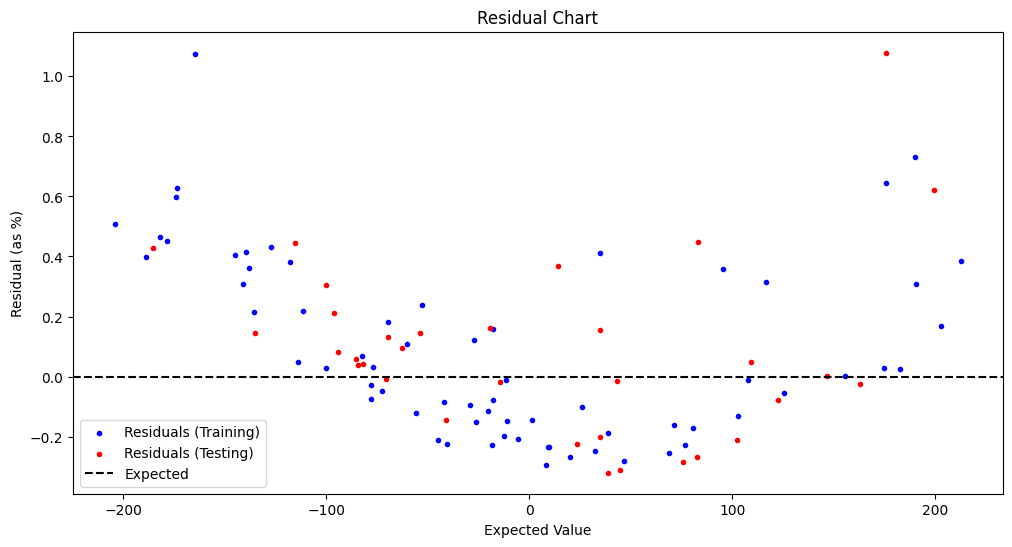

In [22]:
### Plot residuals
plt.title('Residual Chart')
plt.xlabel('Expected Value')
plt.ylabel('Residual (as %)')
plt.scatter(x=zt_tr, y=dz_tr, marker='.', color='blue', label='Residuals (Training)')
plt.scatter(x=zt_ts, y=dz_ts, marker='.', color='red', label='Residuals (Testing)')
plt.axhline(0, linestyle='--', color='black', label='Expected')
plt.legend(loc='best', ncol=1)
plt.show()

## Write your observations here

- Task 1:
- Task 2:
- Task 3:
- Task 4:
- Task 5:
- Challenge:
- Reflection:

## Challenge task:<br>Apply your model to the Swiss Roll data set 2 (in own time)

In [23]:
from sklearn.datasets import make_swiss_roll

np.random.seed(42)
data_seed = 42
n_samples = 1000 # Reduce to 300
noise = 0.2

X_raw, y_raw = make_swiss_roll(
    n_samples=n_samples,
    noise=0,
    random_state=data_seed,
    hole=False # With the hole it is harder
)

In [24]:
import plotly as ply
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

# Create an interactive 3D scatter plot, of the first two columns
fig = px.scatter_3d(x=X_raw[:, 0], y=X_raw[:, 1], z=X_raw[:, 2], 
                    title='Interactive 3D Scatter Plot',
                    labels={'x': 'Feature x', 
                            'y': 'Feature y', 
                            'z': 'Feature z'},
                    color=y_raw, 
                    color_continuous_scale = ply.colors.sequential.Turbo)
mrg = dict(l = 50, r = 50, b = 50, t = 50, pad = 10)
fig.update_traces(marker=dict(size=3, symbol='circle'))
fig.update_layout(width=600, height=600, margin = mrg, paper_bgcolor = 'whitesmoke')
fig.show()

## Systems in use

In [25]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
